In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [150]:
df = pd.read_csv('aac_intakes_outcomes.csv', parse_dates=True)
df.shape

(79672, 41)

In [151]:
df.head()

,age_upon_outcome,animal_id_outcome,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,...,age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days
0,10 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,...,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194
1,7 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,...,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722
2,6 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2190,6.0,"(5.0, 7.5]",2014-03-08 17:10:00,...,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889
3,10 years,A047759,2004-04-02 00:00:00,Partner,Transfer,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,...,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139
4,16 years,A134067,1997-10-16 00:00:00,NaN,Return to Owner,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,...,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79672 entries, 0 to 79671
Data columns (total 41 columns):
age_upon_outcome              79672 non-null object
animal_id_outcome             79672 non-null object
date_of_birth                 79672 non-null object
outcome_subtype               36348 non-null object
outcome_type                  79662 non-null object
sex_upon_outcome              79671 non-null object
age_upon_outcome_(days)       79672 non-null int64
age_upon_outcome_(years)      79672 non-null float64
age_upon_outcome_age_group    79672 non-null object
outcome_datetime              79672 non-null object
outcome_month                 79672 non-null int64
outcome_year                  79672 non-null int64
outcome_monthyear             79672 non-null object
outcome_weekday               79672 non-null object
outcome_hour                  79672 non-null int64
outcome_number                79672 non-null float64
dob_year                      79672 non-null int64
dob_month 

In [153]:
df['animal_type'].describe()

count     79672
unique        4
top         Dog
freq      45366
Name: animal_type, dtype: object

In [154]:
df['animal_type'].unique()

array(['Dog', 'Cat', 'Other', 'Bird'], dtype=object)

In [155]:
df['breed'].nunique()

2155

In [156]:
df.describe()

,age_upon_outcome_(days),age_upon_outcome_(years),outcome_month,outcome_year,outcome_hour,outcome_number,dob_year,dob_month,count,age_upon_intake_(days),age_upon_intake_(years),intake_month,intake_year,intake_hour,intake_number,time_in_shelter_days
count,79672.000000,79672.000000,79672.000000,79672.000000,79672.000000,79672.000000,79672.000000,79672.000000,79672.0,79672.000000,79672.000000,79672.000000,79672.000000,79672.000000,79672.000000,79672.000000
mean,782.046127,2.142592,6.655425,2015.472563,14.297306,1.126820,2013.254870,6.310310,1.0,769.341701,2.107785,6.584032,2015.436101,13.487022,1.126820,16.757116
std,1058.528519,2.900078,3.414284,1.305944,3.774317,0.456057,3.216517,3.289077,0.0,1056.009040,2.893175,3.366579,1.303157,3.121173,0.456057,41.679359
min,0.000000,0.000000,1.000000,2013.000000,0.000000,1.000000,1991.000000,1.000000,1.0,0.000000,0.000000,1.000000,2013.000000,0.000000,1.000000,0.000000
25%,90.000000,0.246575,4.000000,2014.000000,12.000000,1.000000,2012.000000,4.000000,1.0,60.000000,0.164384,4.000000,2014.000000,11.000000,1.000000,1.102083
50%,365.000000,1.000000,7.000000,2015.000000,15.000000,1.000000,2014.000000,6.000000,1.0,365.000000,1.000000,7.000000,2015.000000,13.000000,1.000000,4.987153
75%,1095.000000,3.000000,10.000000,2017.000000,17.000000,1.000000,2015.000000,9.000000,1.0,1095.000000,3.000000,10.000000,2017.000000,16.000000,1.000000,13.610764
max,9125.000000,25.000000,12.000000,2018.000000,23.000000,13.000000,2018.000000,12.000000,1.0,9125.000000,25.000000,12.000000,2018.000000,23.000000,13.000000,1606.194444


In [157]:
dogs = df[df['animal_type'] == 'Dog']
cats = df[df['animal_type'] == 'Cat']
birds = df[df['animal_type'] == 'Bird']
other = df[df['animal_type'] == 'Other']

In [198]:
breed_counts = dogs['breed'].value_counts()
breed_counts

Pit Bull Mix                                            6256
Chihuahua Shorthair Mix                                 4831
Labrador Retriever Mix                                  4789
German Shepherd Mix                                     1950
Australian Cattle Dog Mix                               1099
Dachshund Mix                                            811
Boxer Mix                                                683
Border Collie Mix                                        662
Miniature Poodle Mix                                     662
Catahoula Mix                                            480
Rat Terrier Mix                                          469
Australian Shepherd Mix                                  468
Yorkshire Terrier Mix                                    447
Siberian Husky Mix                                       441
Jack Russell Terrier Mix                                 429
Miniature Schnauzer Mix                                  402
Beagle Mix              

In [158]:
dogs.breed = dogs['breed'].str.replace('Black/Tan Hound', 'Black-Tan Hound')
dogs['breed_nomix'] = dogs['breed'].str.replace(' Mix', '')
dogs['breed_list'] = dogs['breed_nomix'].str.split('/')
dogs['mix_count'] = dogs['breed_list'].str.len()
dogs.loc[dogs['mix_count']>1, 'mixed_breed'] = 1
dogs.loc[dogs['breed'].str.contains('Mix'), 'mixed_breed'] = 1
dogs['mixed_breed'] = dogs['mixed_breed'].fillna(0)
dogs.sort_index(axis=0)
dogs[['breed', 'breed_list', 'mixed_breed']]

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,breed,breed_list,mixed_breed
0,Spinone Italiano Mix,[Spinone Italiano],1.0
1,Spinone Italiano Mix,[Spinone Italiano],1.0
2,Spinone Italiano Mix,[Spinone Italiano],1.0
3,Dachshund,[Dachshund],0.0
4,Shetland Sheepdog,[Shetland Sheepdog],0.0
5,Labrador Retriever/Pit Bull,"[Labrador Retriever, Pit Bull]",1.0
6,Miniature Schnauzer Mix,[Miniature Schnauzer],1.0
7,Lhasa Apso Mix,[Lhasa Apso],1.0
8,Shetland Sheepdog Mix,[Shetland Sheepdog],1.0
9,Shetland Sheepdog Mix,[Shetland Sheepdog],1.0


In [181]:
has_breeds = pd.get_dummies(dogs['breed_list'].apply(pd.Series).stack()).sum(level=0)

,Affenpinscher,Afghan Hound,Airedale Terrier,Akbash,Akita,Alaskan Husky,Alaskan Malamute,American Bulldog,American Eskimo,American Foxhound,...,Vizsla,Weimaraner,Welsh Springer Spaniel,Welsh Terrier,West Highland,Whippet,Wire Hair Fox Terrier,Wirehaired Pointing Griffon,Yorkshire,Yorkshire Terrier
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [160]:
dogs = pd.concat([dogs, has_breeds], axis=1)

0        1
1        1
2        1
3        0
4        0
5        0
6        0
7        0
8        0
9        0
12       0
13       0
14       0
15       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
27       0
28       0
30       0
31       0
32       0
33       0
34       0
        ..
79618    0
79619    0
79621    0
79624    0
79625    0
79626    0
79627    0
79628    0
79630    0
79631    0
79632    0
79633    0
79634    0
79635    0
79642    0
79643    0
79644    0
79645    0
79646    0
79647    0
79649    0
79652    0
79653    0
79654    0
79655    0
79656    0
79657    0
79660    0
79670    0
79671    0
Name: Spinone Italiano, Length: 45366, dtype: uint8

In [180]:
dogs = dogs.sort_index(axis=0)
dogs

,age_upon_outcome,animal_id_outcome,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,...,Vizsla,Weimaraner,Welsh Springer Spaniel,Welsh Terrier,West Highland,Whippet,Wire Hair Fox Terrier,Wirehaired Pointing Griffon,Yorkshire,Yorkshire Terrier
0,10 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,3650,10.000000,"(7.5, 10.0]",2017-12-07 14:07:00,...,0,0,0,0,0,0,0,0,0,0
1,7 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2555,7.000000,"(5.0, 7.5]",2014-12-20 16:35:00,...,0,0,0,0,0,0,0,0,0,0
2,6 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2190,6.000000,"(5.0, 7.5]",2014-03-08 17:10:00,...,0,0,0,0,0,0,0,0,0,0
3,10 years,A047759,2004-04-02 00:00:00,Partner,Transfer,Neutered Male,3650,10.000000,"(7.5, 10.0]",2014-04-07 15:12:00,...,0,0,0,0,0,0,0,0,0,0
4,16 years,A134067,1997-10-16 00:00:00,NaN,Return to Owner,Neutered Male,5840,16.000000,"(15.0, 17.5]",2013-11-16 11:54:00,...,0,0,0,0,0,0,0,0,0,0
5,15 years,A141142,1998-06-01 00:00:00,NaN,Return to Owner,Spayed Female,5475,15.000000,"(12.5, 15.0]",2013-11-17 11:40:00,...,0,0,0,0,0,0,0,0,0,0
6,15 years,A163459,1999-10-19 00:00:00,NaN,Return to Owner,Intact Female,5475,15.000000,"(12.5, 15.0]",2014-11-14 19:28:00,...,0,0,0,0,0,0,0,0,0,0
7,15 years,A165752,1999-08-18 00:00:00,NaN,Return to Owner,Neutered Male,5475,15.000000,"(12.5, 15.0]",2014-09-15 16:35:00,...,0,0,0,0,0,0,0,0,0,0
8,15 years,A178569,1999-03-17 00:00:00,NaN,Return to Owner,Neutered Male,5475,15.000000,"(12.5, 15.0]",2014-03-23 15:57:00,...,0,0,0,0,0,0,0,0,0,0
9,18 years,A189592,1997-08-01 00:00:00,NaN,Return to Owner,Spayed Female,6570,18.000000,"(17.5, 20.0]",2015-09-18 19:04:00,...,0,0,0,0,0,0,0,0,0,0


In [286]:
breed_melt1 = dogs[['breed_list', 'mixed_breed', 'time_in_shelter_days']]
breed_melt2 = dogs.loc[:, 'Affenpinscher':]
breed_melt = pd.concat([breed_melt1, breed_melt2], axis=1)
breed_melted = pd.melt(breed_melt, id_vars=['breed_list','mixed_breed','time_in_shelter_days'], 
                       var_name='breed_name', value_name='has_breed')
breed_melted.loc[breed_melted['has_breed']==1, 'breed'] = breed_melted['breed_name']
breed_melted

,breed_list,mixed_breed,time_in_shelter_days,breed_name,has_breed,breed
0,[Spinone Italiano],1.0,0.588194,Affenpinscher,0,NaN
1,[Spinone Italiano],1.0,1.259722,Affenpinscher,0,NaN
2,[Spinone Italiano],1.0,1.113889,Affenpinscher,0,NaN
3,[Dachshund],0.0,4.970139,Affenpinscher,0,NaN
4,[Shetland Sheepdog],0.0,0.119444,Affenpinscher,0,NaN
5,"[Labrador Retriever, Pit Bull]",1.0,0.870833,Affenpinscher,0,NaN
6,[Miniature Schnauzer],1.0,0.178472,Affenpinscher,0,NaN
7,[Lhasa Apso],1.0,0.213194,Affenpinscher,0,NaN
8,[Shetland Sheepdog],1.0,6.258333,Affenpinscher,0,NaN
9,[Shetland Sheepdog],1.0,0.054167,Affenpinscher,0,NaN


In [282]:
common_breeds = breed_melted.groupby('breed').sum()
common_breeds.sort_values('has_breed', ascending=False)
other_breeds = common_breeds.loc[common_breeds['has_breed']<400,:]
other_breeds_list = other_breeds.index.tolist()
other_breeds_list

['Affenpinscher',
 'Afghan Hound',
 'Airedale Terrier',
 'Akbash',
 'Akita',
 'Alaskan Husky',
 'Alaskan Malamute',
 'American Eskimo',
 'American Foxhound',
 'American Pit Bull Terrier',
 'American Staffordshire Terrier',
 'Australian Kelpie',
 'Australian Terrier',
 'Basenji',
 'Basset Hound',
 'Bearded Collie',
 'Beauceron',
 'Bedlington Terr',
 'Belgian Malinois',
 'Belgian Sheepdog',
 'Belgian Tervuren',
 'Bernese Mountain Dog',
 'Bichon Frise',
 'Black Mouth Cur',
 'Black-Tan Hound',
 'Bloodhound',
 'Blue Lacy',
 'Bluetick Hound',
 'Boerboel',
 'Border Terrier',
 'Borzoi',
 'Boston Terrier',
 'Bouv Flandres',
 'Boykin Span',
 'Brittany',
 'Bruss Griffon',
 'Bull Terrier',
 'Bull Terrier Miniature',
 'Bulldog',
 'Bullmastiff',
 'Canaan Dog',
 'Cane Corso',
 'Cardigan Welsh Corgi',
 'Carolina Dog',
 'Cavalier Span',
 'Chesa Bay Retr',
 'Chinese Crested',
 'Chinese Sharpei',
 'Chow Chow',
 'Cirneco',
 'Cocker Spaniel',
 'Collie Rough',
 'Collie Smooth',
 'Coton De Tulear',
 'Dachshu

In [290]:
breed_subset = breed_melted.copy()
breed_subset.loc[breed_subset['breed'].isin(other_breeds_list), 'breed_category'] = 'Other'
breed_subset.loc[~breed_subset['breed'].isin(other_breeds_list), 'breed_category'] = breed_subset['breed']
breed_subset

,breed_list,mixed_breed,time_in_shelter_days,breed_name,has_breed,breed,breed_category
0,[Spinone Italiano],1.0,0.588194,Affenpinscher,0,NaN,NaN
1,[Spinone Italiano],1.0,1.259722,Affenpinscher,0,NaN,NaN
2,[Spinone Italiano],1.0,1.113889,Affenpinscher,0,NaN,NaN
3,[Dachshund],0.0,4.970139,Affenpinscher,0,NaN,NaN
4,[Shetland Sheepdog],0.0,0.119444,Affenpinscher,0,NaN,NaN
5,"[Labrador Retriever, Pit Bull]",1.0,0.870833,Affenpinscher,0,NaN,NaN
6,[Miniature Schnauzer],1.0,0.178472,Affenpinscher,0,NaN,NaN
7,[Lhasa Apso],1.0,0.213194,Affenpinscher,0,NaN,NaN
8,[Shetland Sheepdog],1.0,6.258333,Affenpinscher,0,NaN,NaN
9,[Shetland Sheepdog],1.0,0.054167,Affenpinscher,0,NaN,NaN


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 27 Text xticklabel objects>)

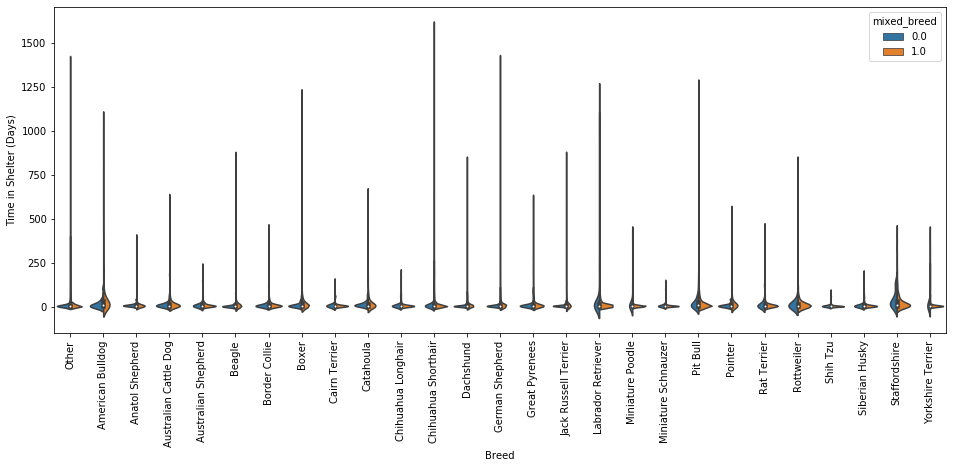

In [298]:
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x='breed_category', y='time_in_shelter_days', hue='mixed_breed', 
                    data=breed_subset, split=True)
plt.xlabel('Breed')
plt.ylabel('Time in Shelter (Days)')
plt.legend()
plt.xticks(rotation=90)

In [ ]:
from scipy import stats

In [165]:
#dogs[['breed1','breed2']] = dogs['breed'].str.split('/', expand=True)
#breeds_split = dogs.pivot_table(index=['breed1','breed2'], aggfunc='mean')
#breeds_split = breeds.sort_values(by='time_in_shelter_days', ascending=False)
#breeds_split['count'] = dogs['breed'].value_counts()
#breeds_split = breeds_split.sort_values(by='count', ascending=True)
#breeds_split

In [166]:
#need to repeat and filter by dog breeds v cat v other animals
#breeds = dogs.pivot_table(index=['breed1','breed2'], aggfunc='mean')
#breeds = breeds.sort_values(by='time_in_shelter_days', ascending=False)
#breeds.sort_index()
#breeds.unstack(level='breed2')
#breeds.swaplevel(0,1)
# this doesn't work for mulitindex -> breeds.loc[breeds.index.isnull(), :]

#breeds.index.set_levels([l.fillna('Purebreed') for l in breeds.index.levels], inplace=True)
#breeds.loc[('Pit Bull Mix', slice(None)),:]

In [167]:
#for analysis related to time of year, use df.resample('D' (or other here - 'W', 'B' (business days), 'H')).mean() 
#to see # adopted by day/month/week whatever
#can also use .count()

#maybe use #rolling to smooth out curves

#groupby 